# 2022机器学习期末大作业
- 姓名：高祎珂&emsp;郑凌伟&emsp;李越
- 学号：2011743&emsp;2013210&emsp;2011619
- 专业：计算机科学与技术

## 题目：基于VAE的手写数字生成

### 基本要求:
利用 pytorch (推荐) 或 tensorflow 等神经网络框架编程实现一个变分自编码器 (Variational Auto Encoder, VAE)；分别采用交叉熵损失 (Cross Entropy Loss) 和L2损失 (MSE Loss) 构建损失函数生成新的手写数字,分析结果并展示生成的手写数字；

### 中级要求:
实现VAE的变分推断(最好是手写推导)，描述VAE的由来以及优缺点；

### 高级要求:
实现任意形式的对VAE进行改进或创新，例如：和其他网络结合或对比（图卷积神经网络(GCN)，生成对抗网络(GAN)，Diffusion Model等）；实现VAE的变种（β-VAE，β-TCVAE等）；修改数据集（例如加噪点，加mask等）以发掘VAE更多的功能；对可视化方法进行创新（例如输出隐变量）……

### 小组分工:
李越同学负责基本要求的实现，高祎珂同学负责中级要求，郑凌伟同学负责高级要求

In [32]:
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os
import datetime

In [33]:
# 定义VAE类
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        INOUT_num = 784                                          # 输入（输出）大小
        hidden_num1 = 400                                        # 隐藏层大小
        hidden_num2 = 20                                         # 隐变量大小
        self.fc1 = nn.Linear(INOUT_num, hidden_num1)             # （编码） 全连接层
        self.fc21 = nn.Linear(hidden_num1, hidden_num2)          # （编码） 计算 mean
        self.fc22 = nn.Linear(hidden_num1, hidden_num2)          # （编码） 计算 logvar
        self.fc3 = nn.Linear(hidden_num2, hidden_num1)           # （解码） 隐藏层
        self.fc4 = nn.Linear(hidden_num1, INOUT_num)             # （解码） 输出层
 
    def encode(self, x):
        # 全连接层
        hidden1 = self.fc1(x)
        # relu层
        h1 = F.relu(hidden1)
        # 计算mean
        mu = self.fc21(h1)
        # 计算var
        logvar = self.fc22(h1)
        return mu, logvar
 
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()                            # mul是乘法的意思，然后exp_是求e的次方并修改原数值  所有带"—"都是inplace的 意思就是操作后 原数也会改动 
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()  # 在cuda中生成一个std.size()的张量，标准正态分布采样，类型为FloatTensor
        else:
            eps = torch.FloatTensor(std.size()).normal_()       # 生成一个std.size()的张量，正态分布，类型为FloatTensor
        eps = Variable(eps)                                     # Variable是torch.autograd中很重要的类。它用来包装Tensor，将Tensor转换为Variable之后，可以装载梯度信息。
        repar = eps.mul(std).add_(mu)
        return repar
 
    def decode(self, z):
        # 隐藏层
        hidden2 = self.fc3(z)
        # relu层
        h3 = F.relu(hidden2)
        # 隐藏层
        hidden3 = self.fc4(h3)
        # sigmoid层
        output = F.sigmoid(hidden3)
        return output
 
    def forward(self, x):
        mu, logvar = self.encode(x)           # 编码
        z = self.reparametrize(mu, logvar)    # 重新参数化成正态分布
        decodez = self.decode(z)              # 解码
        return decodez, mu, logvar


In [34]:
# 图像转为二维可视化
def to_img(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    BCE = reconstruction_function(recon_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return BCE + KLD

#### VAE参数设置及数据加载

In [35]:
#  VAE参数设置
num_epochs = 40
batch_size = 128
learning_rate = 1e-3
# 定义数据格式
img_transform = transforms.Compose([
    transforms.ToTensor()   # 将原始的PILImage格式或者numpy.array格式的数据格式化为可被pytorch快速处理的张量类型。
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])  # orchvision.transforms是pytorch中的图像预处理包。一般用Compose把多个步骤整合到一起：
# 加载数据
dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### 使用交叉熵损失 (Cross Entropy Loss)构建损失函数

In [36]:
#  创建路径
if not os.path.exists('./vae_CEL_img'):
    os.mkdir('./vae_CEL_img')

strattime = datetime.datetime.now()
model = VAE() # 实例化VAE  
if torch.cuda.is_available():
    # model.cuda()
    print('cuda is OK!')
    model = model.to('cuda')
else:
    print('cuda is NO!')

#reconstruction_function = nn.MSELoss(size_average=False)   # 定义损失函数，可修改其他
reconstruction_function = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

#开始训练
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        if torch.cuda.is_available():
            img = img.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(img)
        loss = loss_function(recon_batch, img, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            endtime = datetime.datetime.now()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}  time:{:.2f}s'.format(
                epoch,
                batch_idx * len(img),
                len(dataloader.dataset), 100. * batch_idx / len(dataloader),
                loss.item() / len(img),
                (endtime-strattime).seconds))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(dataloader.dataset)))
    if epoch % 10 == 0:  
        #  重构图像
        save = to_img(recon_batch.cpu().data)
        save_image(save, './vae_CEL_img/image_{}.png'.format(epoch))

cuda is OK!
Train Epoch: 0 [0/60000 (0%)]	Loss: 687.499512  time:0.00s
Train Epoch: 0 [12800/60000 (21%)]	Loss: 617.946228  time:2.00s
Train Epoch: 0 [25600/60000 (43%)]	Loss: 626.684509  time:4.00s
Train Epoch: 0 [38400/60000 (64%)]	Loss: 640.339661  time:5.00s
Train Epoch: 0 [51200/60000 (85%)]	Loss: 621.927307  time:7.00s
====> Epoch: 0 Average loss: 637.5829
Train Epoch: 1 [0/60000 (0%)]	Loss: 597.177185  time:9.00s
Train Epoch: 1 [12800/60000 (21%)]	Loss: 654.298340  time:11.00s
Train Epoch: 1 [25600/60000 (43%)]	Loss: 655.070374  time:13.00s
Train Epoch: 1 [38400/60000 (64%)]	Loss: 635.523621  time:15.00s
Train Epoch: 1 [51200/60000 (85%)]	Loss: 639.611206  time:17.00s
====> Epoch: 1 Average loss: 634.1258
Train Epoch: 2 [0/60000 (0%)]	Loss: 635.623535  time:18.00s
Train Epoch: 2 [12800/60000 (21%)]	Loss: 664.170227  time:20.00s
Train Epoch: 2 [25600/60000 (43%)]	Loss: 620.535522  time:22.00s
Train Epoch: 2 [38400/60000 (64%)]	Loss: 629.571472  time:24.00s
Train Epoch: 2 [51200/6

#### 结果展示

CEL第一张图片


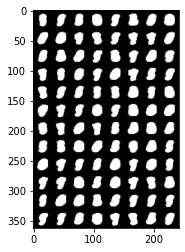

In [37]:
def read_image(filename):
    import matplotlib.image as mpimg
    import matplotlib.pyplot as plt
    image = mpimg.imread(filename) #读入图像
    plt.imshow(image)
CEL_img1 = './vae_CEL_img/image_0.png'
CEL_img2 = './vae_CEL_img/image_30.png'
print("CEL第一张图片")
read_image(CEL_img1)


CEL第三张图片


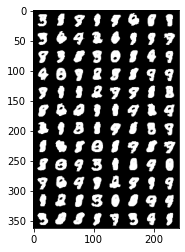

In [38]:
print("CEL第三张图片")
read_image(CEL_img2)

In [39]:
# 模型保存
torch.save(model.state_dict(), './vae.pth')

### 使用L2损失 (MSE Loss) 构建损失函数

In [40]:
#  创建路径
if not os.path.exists('./vae_MSEL_img'):
    os.mkdir('./vae_MSEL_img')

strattime = datetime.datetime.now()
model = VAE() # 实例化VAE  
if torch.cuda.is_available():
    # model.cuda()
    print('cuda is OK!')
    model = model.to('cuda')
else:
    print('cuda is NO!')

reconstruction_function = nn.MSELoss(size_average=False)   # 定义损失函数，可修改其他
#reconstruction_function = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

#开始训练
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        if torch.cuda.is_available():
            img = img.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(img)
        loss = loss_function(recon_batch, img, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            endtime = datetime.datetime.now()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}  time:{:.2f}s'.format(
                epoch,
                batch_idx * len(img),
                len(dataloader.dataset), 100. * batch_idx / len(dataloader),
                loss.item() / len(img),
                (endtime-strattime).seconds))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(dataloader.dataset)))
    if epoch % 10 == 0:  
        #  重构图像
        save = to_img(recon_batch.cpu().data)
        save_image(save, './vae_MSEL_img/image_{}.png'.format(epoch))

cuda is OK!
Train Epoch: 0 [0/60000 (0%)]	Loss: 184.200119  time:0.00s
Train Epoch: 0 [12800/60000 (21%)]	Loss: 48.171471  time:2.00s
Train Epoch: 0 [25600/60000 (43%)]	Loss: 41.873081  time:4.00s
Train Epoch: 0 [38400/60000 (64%)]	Loss: 39.006912  time:6.00s
Train Epoch: 0 [51200/60000 (85%)]	Loss: 39.285278  time:8.00s
====> Epoch: 0 Average loss: 45.0768
Train Epoch: 1 [0/60000 (0%)]	Loss: 38.067093  time:10.00s
Train Epoch: 1 [12800/60000 (21%)]	Loss: 36.115845  time:12.00s
Train Epoch: 1 [25600/60000 (43%)]	Loss: 33.849941  time:14.00s
Train Epoch: 1 [38400/60000 (64%)]	Loss: 34.268070  time:16.00s
Train Epoch: 1 [51200/60000 (85%)]	Loss: 33.333427  time:18.00s
====> Epoch: 1 Average loss: 35.0378
Train Epoch: 2 [0/60000 (0%)]	Loss: 32.492130  time:19.00s
Train Epoch: 2 [12800/60000 (21%)]	Loss: 33.301559  time:21.00s
Train Epoch: 2 [25600/60000 (43%)]	Loss: 33.244354  time:23.00s
Train Epoch: 2 [38400/60000 (64%)]	Loss: 31.649887  time:25.00s
Train Epoch: 2 [51200/60000 (85%)]	Lo

#### 结果展示

MSEL第一张图片


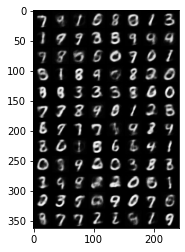

In [41]:
def read_image(filename):
    import matplotlib.image as mpimg
    import matplotlib.pyplot as plt
    image = mpimg.imread(filename) #读入图像
    plt.imshow(image)
MSEL_img1 = './vae_MSEL_img/image_0.png'
MSEL_img2 = './vae_MSEL_img/image_30.png'
print("MSEL第一张图片")
read_image(MSEL_img1)

MSEL第三张图片


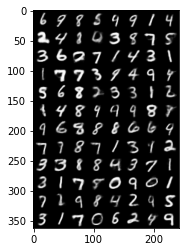

In [42]:
print("MSEL第三张图片")
read_image(MSEL_img2)

#### 模型保存

In [43]:
torch.save(model.state_dict(), './vaeCEL.pth')

## VAE的变分推断

### 问题引入

VAE是一个生成模型，我们的最终目标是如何构建一个生成模型，也就是联合概率，我们并不知道变量满足什么分布，为了解决假设分布的弊端，引入隐变量模型。

<img src="1.png" alt="1" style="zoom: 50%;" />


但是采样数m多少合适就成了一个问题。假设p(z)是标准高斯分布，那么其实这个过程采样出来的x也服从高斯分布，对服从高斯分布的 x进行极大似然估计等价于最小化均方误差（MSE），如果采样数少的话，很难采样生成较好的结果。为了解决这个问题，VAE采取的方法是缩小z的取值空间。缩小 p(z) 的方差 σ<sup>2</sup>，那么 z 的采样范围会缩小，采样的次数 m也不需要那么大。同时，也可能把生成坏样本的 z 排除，生成更像真实样本的图像。

### 变分推断

怎么能缩小 z 的取值空间呢？**原来 z 从先验概率分布 p(z) 中采样，现在可以考虑从 z 的后验概率分布p(z|X) 中采样**

因此问题就变成了求隐变量的后验概率分布p(z|X) ，我们无法准确求出后验概率的，可以用另一个分布 q<sub>θ</sub>(z|X) 近似估计 p(z|X) ，然后从 q<sub>θ</sub>(z|X) 中采样来近似从 p(z|X) 中采样，这其实是要用一个函数近似另一个函数，可以用变分法来解决。自变量是 q<sub>θ</sub>(z|X) 的密度函数，因变量是 q<sub>θ</sub>(z|X) 与真实后验密度函数 p(z|X) 的“距离”，而这个函数 f 关于概率密度函数的“导数”就叫做变分。

变分推断中采用KL散度作为度量两个概率分布的相似程度，公式推导如下：

<img src="2.png" alt="2" style="zoom:50%;" />

上式的右边就是VAE的目标函数ELBO（Evidence Lower Bound），第一项中 z∼q<sub>θ</sub>(z|x) 表示有一个 x 可以根据分布 q<sub>θ</sub>(z|x) 采样一个 z ，这个过程可以理解为把 x 编码成 z ，此过程被称为Encoder。 p(x|z) 表示根据 z 生成 x ，此过程被称为Decoder。接下来就是要最大化ELBO,实现Encoder和Decoder。VAE模型架构这里不再展示，下面是公式的推导过程：

<img src="3.png" alt="3" style="zoom:70%;" />

至此我们就得出了一个可以计算的目标函数，VAE变分推断结束。

### VAE总结

##### **由来**

这个问题其实在前面已经涉及到了，再利用之前的模型一步步优化的时候，我们转变为了要求隐变量的**后验概率**，但是对于实际应⽤中的许多模型来说，计算后验概率分布或者计算关于这个后验概率分布的期望是不可⾏的，潜空间维度太高，或者分布形式太过复杂，都导致无法直接计算，因此产生了VAE这种确定性近似算法，它的内核时变分推理，将后验分布通过某种方式分解或者假设后验概率分布有一个具体的参数形式，再限制一下函数类型，这个时候我们就能高效的求出近似解。

##### **优点**

- 变分推断的应用，可以弥补隐空间上的数值空洞。

- 与GAN相比，可以通过编码解码的步骤，直接比较重建图片和原始图片的差异。
- 不只是一个黑盒，有语义上的意义。

##### **缺点**

- 与GAN相比，VAE训练完全依靠一个假设的loss函数和KL逼近真实分布，没有使用对抗网络，生成图像模糊。
- 存在posterior collapse问题，意思是解码器太强大，它充分的学习到了每个输入数据的特征，使得Encoder编码出来的隐分布在离标准高斯很远的时候就能被Decoder还原出来，这样隐空间的存在就失效了。